Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
압축 해제를 시작합니다. 데이터 크기에 따라 시간이 걸릴 수 있습니다...
압축 해제 완료!
Using device: cuda
클래스: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
훈련 데이터 수: 5120, 검증 데이터 수: 1280


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Epoch 1/20
----------
train Loss: 0.9105 Acc: 0.5662
val Loss: 0.8483 Acc: 0.6328

Epoch 2/20
----------
train Loss: 0.5574 Acc: 0.7672
val Loss: 0.3334 Acc: 0.8789

Epoch 3/20
----------
train Loss: 0.1949 Acc: 0.9254
val Loss: 0.2223 Acc: 0.9234

Epoch 4/20
----------
train Loss: 0.1029 Acc: 0.9654
val Loss: 0.2016 Acc: 0.9273

Epoch 5/20
----------
train Loss: 0.0963 Acc: 0.9670
val Loss: 0.1516 Acc: 0.9438

Epoch 6/20
----------
train Loss: 0.0271 Acc: 0.9922
val Loss: 0.1147 Acc: 0.9594

Epoch 7/20
----------
train Loss: 0.0298 Acc: 0.9883
val Loss: 0.1751 Acc: 0.9406

Epoch 8/20
----------
train Loss: 0.0399 Acc: 0.9855
val Loss: 0.1011 Acc: 0.9703

Epoch 9/20
----------
train Loss: 0.0332 Acc: 0.9879
val Loss: 0.1374 Acc: 0.9648

Epoch 10/20
----------
train Loss: 0.0443 Acc: 0.9830
val Loss: 0.0905 Acc: 0.9750

Epoch 11/20
----------
train Loss: 0.0297 Acc: 0.9910
val Loss: 0.1416 Acc: 0.9570

Epoch 12/20
----------
train Loss: 0.0142 Acc: 0.9953
val Loss: 0.1704 Acc: 0.9508

E

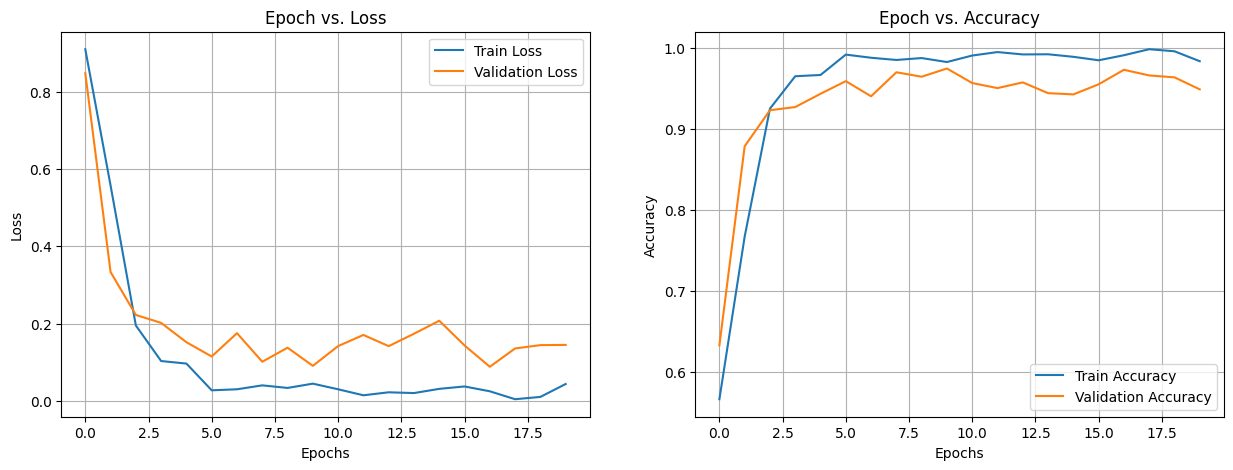

In [ ]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
import timm, matplotlib.pyplot as plt
from google.colab import drive
import os, numpy as np, random

# 1) Drive
drive.mount('/content/drive')

# 2) Paths & device
BASE = '/content/drive/MyDrive/인공지능 튜플'
all_data_dir = f'{BASE}/OriginalDataset'   # 클래스별 폴더 4개가 있는 곳
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# 3) Hyperparams
EPOCHS = 20
BATCH_SIZE = 32
LR = 1e-4
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# 4) Transforms (1채널)
tf_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # 1채널 mean/std
])
tf_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(256), transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# 5) Dataset & split (80/20)
full_dataset = datasets.ImageFolder(all_data_dir, tf_train)
classes = full_dataset.classes
n_total = len(full_dataset)
n_train = int(0.8 * n_total)
n_val   = n_total - n_train
train_ds, val_ds = random_split(full_dataset, [n_train, n_val])
# val엔 val transform 적용
val_ds.dataset.transform = tf_val

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print('클래스:', classes)
print(f'훈련: {len(train_ds)} | 검증: {len(val_ds)}')

# 6) Model (DeiT-S, in_chans=1)
model = timm.create_model('deit_small_patch16_224', pretrained=True, in_chans=1, num_classes=len(classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR)

# 7) Train loop
history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    for phase, loader, tf in [('train', train_loader, tf_train), ('val', val_loader, tf_val)]:
        if phase == 'train': model.train()
        else: model.eval()

        running_loss, running_corrects, total = 0.0, 0, 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)
            with torch.set_grad_enabled(phase=='train'):
                logits = model(x)
                loss = criterion(logits, y)
                if phase=='train':
                    loss.backward(); optimizer.step()
            running_loss += loss.item() * x.size(0)
            running_corrects += (logits.argmax(1) == y).sum().item()
            total += x.size(0)

        ep_loss = running_loss / total
        ep_acc  = running_corrects / total
        print(f'{phase} Loss: {ep_loss:.4f} Acc: {ep_acc:.4f}')
        if phase=='train':
            history['train_loss'].append(ep_loss); history['train_acc'].append(ep_acc)
        else:
            history['val_loss'].append(ep_loss);   history['val_acc'].append(ep_acc)
    print()

print('학습 종료')

# 8) Plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(history['train_loss'], label='Train'); ax1.plot(history['val_loss'], label='Val')
ax1.set_title('Epoch vs Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)

ax2.plot(history['train_acc'], label='Train'); ax2.plot(history['val_acc'], label='Val')
ax2.set_title('Epoch vs Accuracy'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy'); ax2.legend(); ax2.grid(True)
plt.show()
